In [96]:
#######################################################################
#Name of code file: non_dictionary_validation.ipynb

#Data In: CSVs in non_dictionary_validation_data/

#Data Out: Figures validating non-dictionary based method
#Figures A40-A43
######################################################################

In [ ]:
# Import Packages

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.switch_backend('agg')

In [2]:
import os as os
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hac
import seaborn
from adjustText import adjust_text
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import cdist, cosine
from sklearn.manifold import TSNE

In [3]:
#Set Working Directory

In [8]:
os.chdir('../siegel_hatespeech_qjps_replication/')

In [101]:
# Define Plot Features

In [102]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hac.dendrogram(*args, **kwargs)

In [103]:
# Figure A40

In [104]:
n_dim = 100
vectors = pd.read_csv('data/non_dictionary_validation_data/model_individual_softmax.softmax',
                      delimiter=' ',
                      header=None,
                      skiprows=[0])
vectors.drop(n_dim + 1, axis=1, inplace=True)
vectors[0] = vectors[0].str.replace('__label__', '')
vectors.rename(columns={0: 'subreddit'}, inplace=True)
#vectors = vectors.loc[vectors.subreddit.isin(['news']) == False, :]
vectors.set_index('subreddit', inplace=True)
subreddits = list(vectors.index)
vectors = vectors.loc[subreddits, :]
vectors.columns = range(n_dim)
vectors = vectors.loc[subreddits, :]

simil = 1 - cdist(vectors.values, vectors.values, metric='cosine')
simil = pd.DataFrame(simil, index=subreddits, columns=subreddits)

In [105]:
font = {'weight': 'bold', 'size': 22}
axes = {'titlesize': 22, 'labelsize': 22}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axes)
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['lines.linewidth'] = 3.5

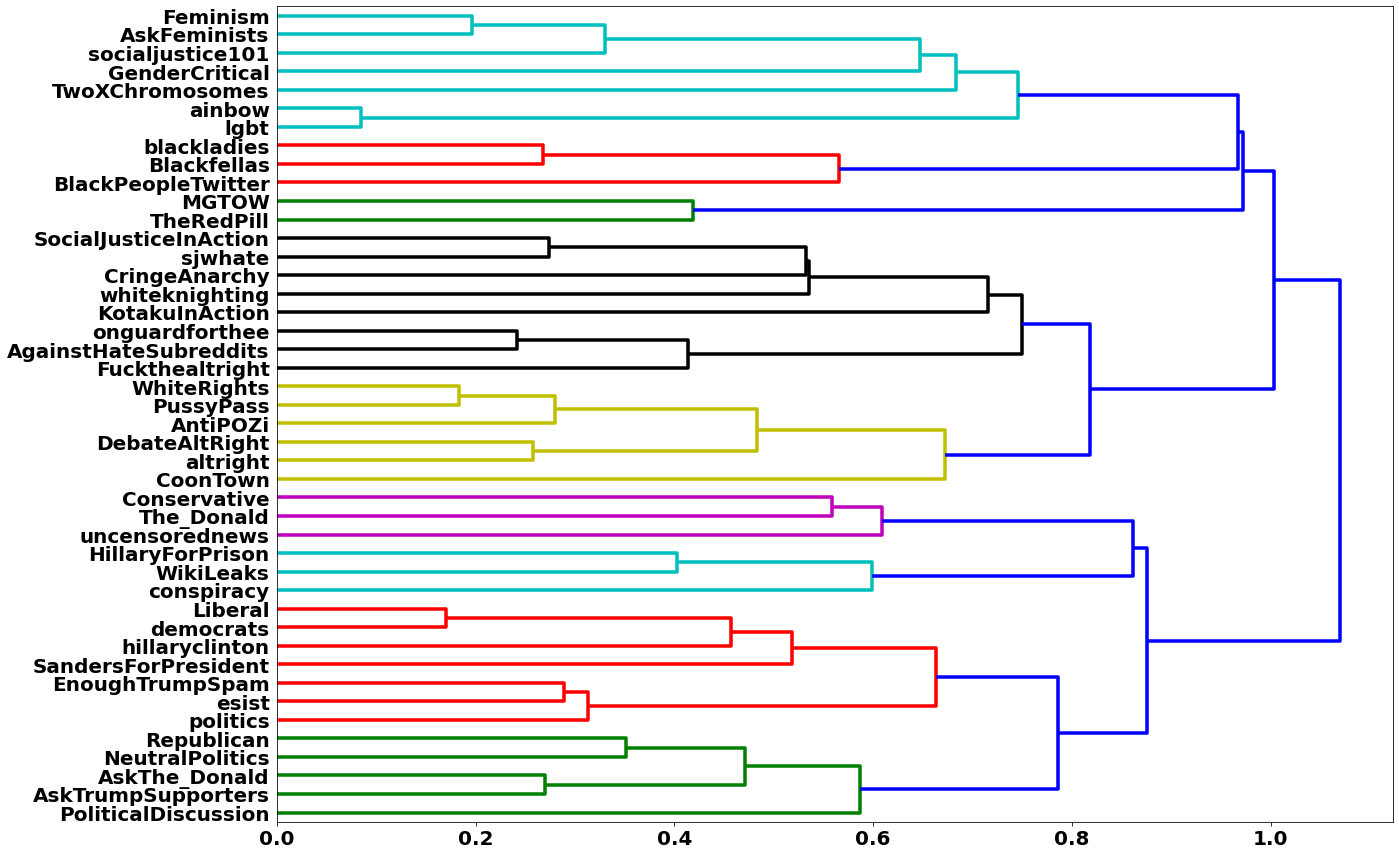

In [106]:
all_subs = [
    subreddit for subreddit in subreddits if subreddit not in [
        'books', 'movies', 'anime', 'Music', 'baseball', 'sports', 'soccer',
        'EarthPorn', 'food', 'Fitness', 'AnimalsBeingJerks', 'funny',
        'AskReddit', 'science', 'technology', 'gaming', '4chan', 'news',
        'Christianity', 'islam', 'Judaism'
    ]
]
z = hac.linkage(vectors.loc[all_subs, :], metric='cosine', method='average')
plt.figure(figsize=(20, 15))
fancy_dendrogram(z,
                 leaf_font_size=20.,
                 labels=all_subs,
                 max_d=0.75,
                 orientation='right',
                 distance_sort=True)
#plt.show()
plt.savefig('figures/figure_A40.pdf', bbox_inches='tight', pad_inches=1)



In [107]:
# Figure A41

In [108]:
def plot_subreddits(vectors,
                    subreddits,
                    max_d=0.75,
                    perplexity=10,
                    random_state=24):
    vectors = vectors.loc[subreddits, :]
    z = hac.linkage(vectors, metric='cosine', method='average')
    clusters = fcluster(z, max_d, criterion='distance') - 1
    df_clust = pd.DataFrame({'subreddits': subreddits, 'cluster': clusters})
    num_cl = len(df_clust.cluster.unique())
    numdocvec = len(subreddits)
    tsne = TSNE(n_components=2,
                perplexity=perplexity,
                early_exaggeration=30.0,
                learning_rate=5,
                n_iter=1500,
                random_state=random_state,
                metric='cosine',
                method='exact')
    #tsne = PCA(n_components = 2, random_state = random_state)
    Y = tsne.fit_transform(vectors)
    fig, ax = plt.subplots(figsize=(22, 22))
    colors = cm.jet(np.linspace(0, 1, num_cl))
    for i in range(num_cl):
        ax.plot(Y[clusters == i, 0],
                Y[clusters == i, 1],
                marker='o',
                linestyle='',
                color=colors[i])
    ax.margins(0.05)
    ax.legend(loc='center left',
              bbox_to_anchor=(1, 0.5),
              fancybox=True,
              shadow=True,
              labels=[],
              fontsize=16)
    texts = []
    for i in range(len(subreddits)):
        texts.append(plt.text(Y[i, 0], Y[i, 1], subreddits[i], fontsize=17))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.55))
    plt.savefig('figures/figure_A41.pdf', bbox_inches='tight', pad_inches=1)


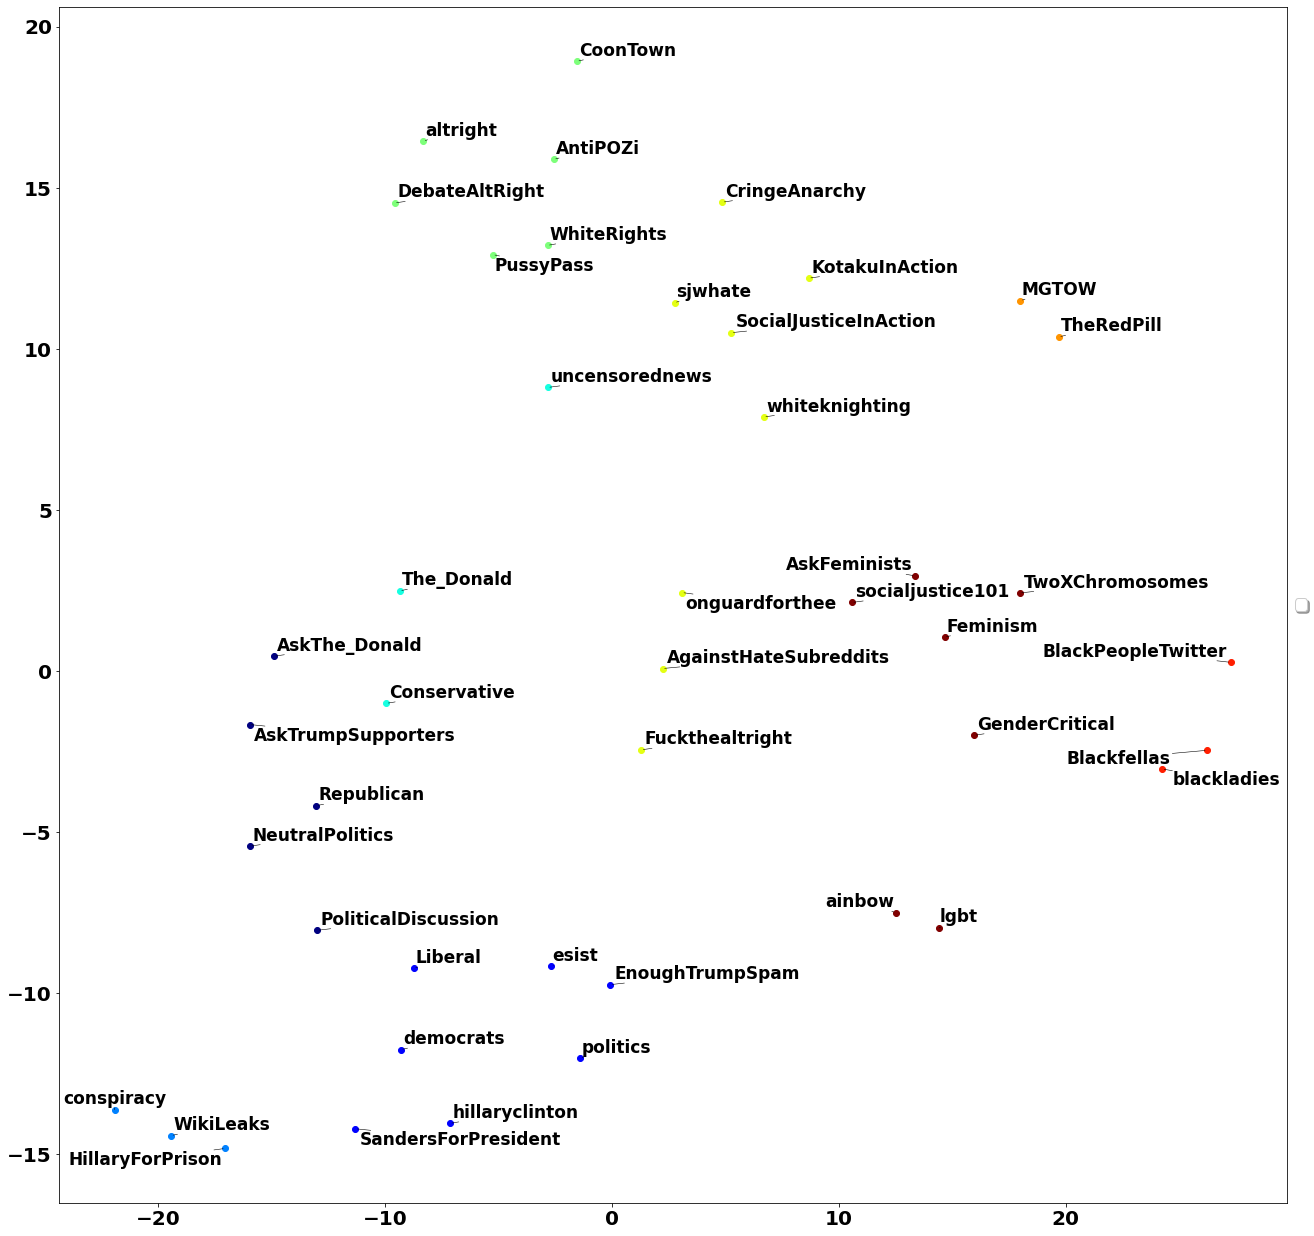

In [109]:
plot_subreddits(vectors, all_subs, perplexity=10, random_state=24)


In [110]:
# Figure A42

In [111]:
n_dim = 100
vectors = pd.read_csv('data/non_dictionary_validation_data/model_groups_softmax.softmax', delimiter = ' ', header = None, skiprows = [0])
vectors.drop(n_dim + 1, axis = 1, inplace = True)
vectors[0] = vectors[0].str.replace('__label__', '')
vectors.rename(columns={0:'subreddit'}, inplace=True)
vectors.set_index('subreddit', inplace = True) 
subreddits = list(vectors.index)
vectors = vectors.loc[subreddits, :]
vectors.columns = range(n_dim)
vectors = vectors.loc[subreddits, :]

simil = 1 - cdist(vectors.values, vectors.values, metric='cosine')
simil = pd.DataFrame(simil, index = subreddits, columns = subreddits)

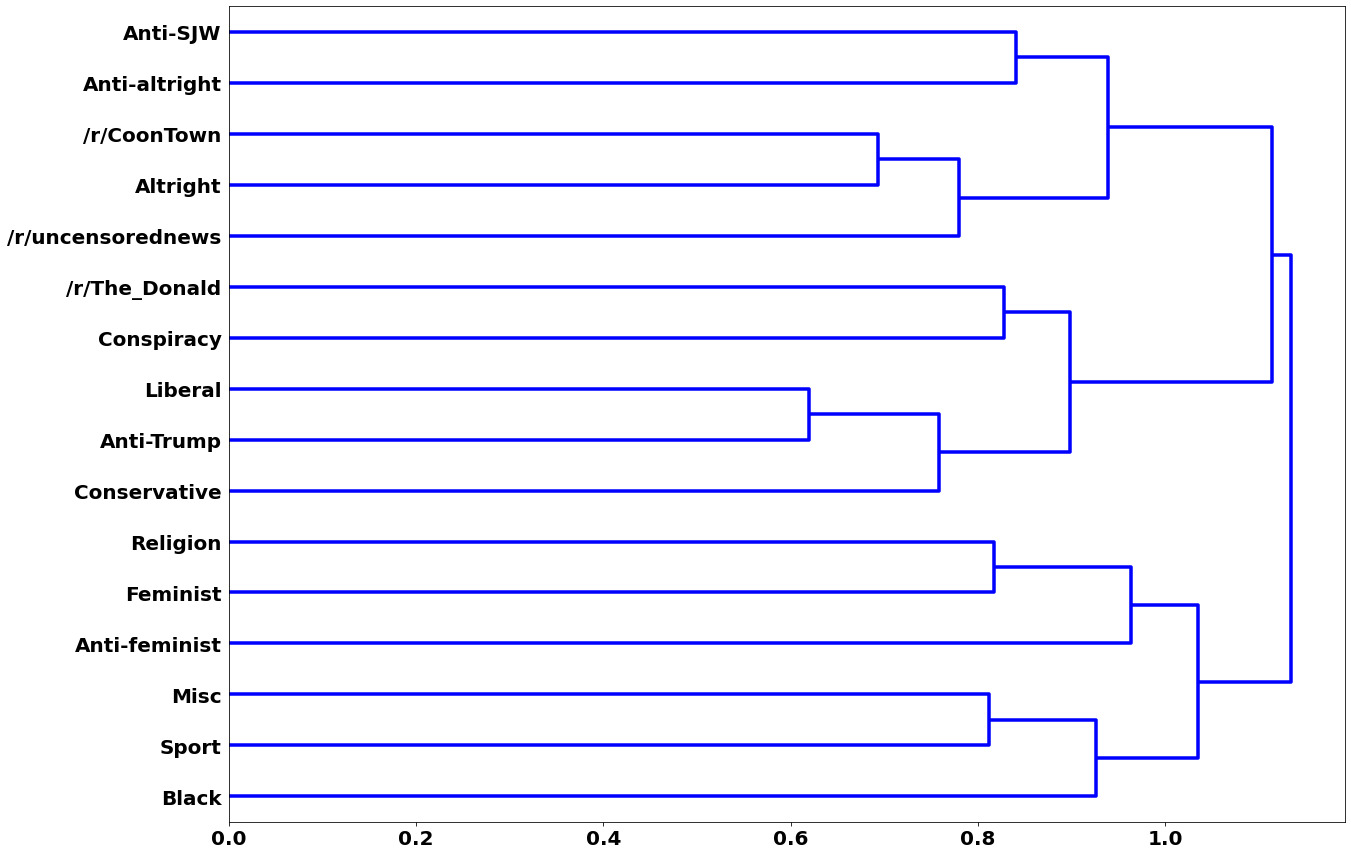

In [112]:
z = hac.linkage(vectors, metric='cosine', method='average')
plt.figure(figsize=(20, 15))
fancy_dendrogram(z,
                 leaf_font_size=20.,
                 labels=subreddits,
                 max_d=0.1,
                 orientation='right',
                 distance_sort=True)
plt.savefig('figures/figure_A42.pdf', bbox_inches='tight', pad_inches=1)

In [113]:
# Figure A43

In [114]:
def get_df_from_probs(prob_file, true_file, subreddits):
    true_labels = pd.read_csv(true_file, header = None)
    probs = pd.read_csv(prob_file, header = None, delimiter = ' ')
    labels = probs.loc[:, ::2].values
    probs = probs.loc[:, 1::2].values
    indices = np.argsort(labels, axis = 1)
    probs = probs[np.arange(probs.shape[0])[:, None], indices]
    probs = pd.DataFrame(probs, index = true_labels[0], columns = sorted(subreddits)).reset_index()
    probs.rename(columns={0:'label'}, inplace=True)
    
    return probs

In [115]:
hate_probs = get_df_from_probs('data/non_dictionary_validation_data/hate_group_hs_probs.csv', 'data/non_dictionary_validation_data/twitter_hate_labels.csv', subreddits)
hate_probs_gr = hate_probs.groupby('label').mean()

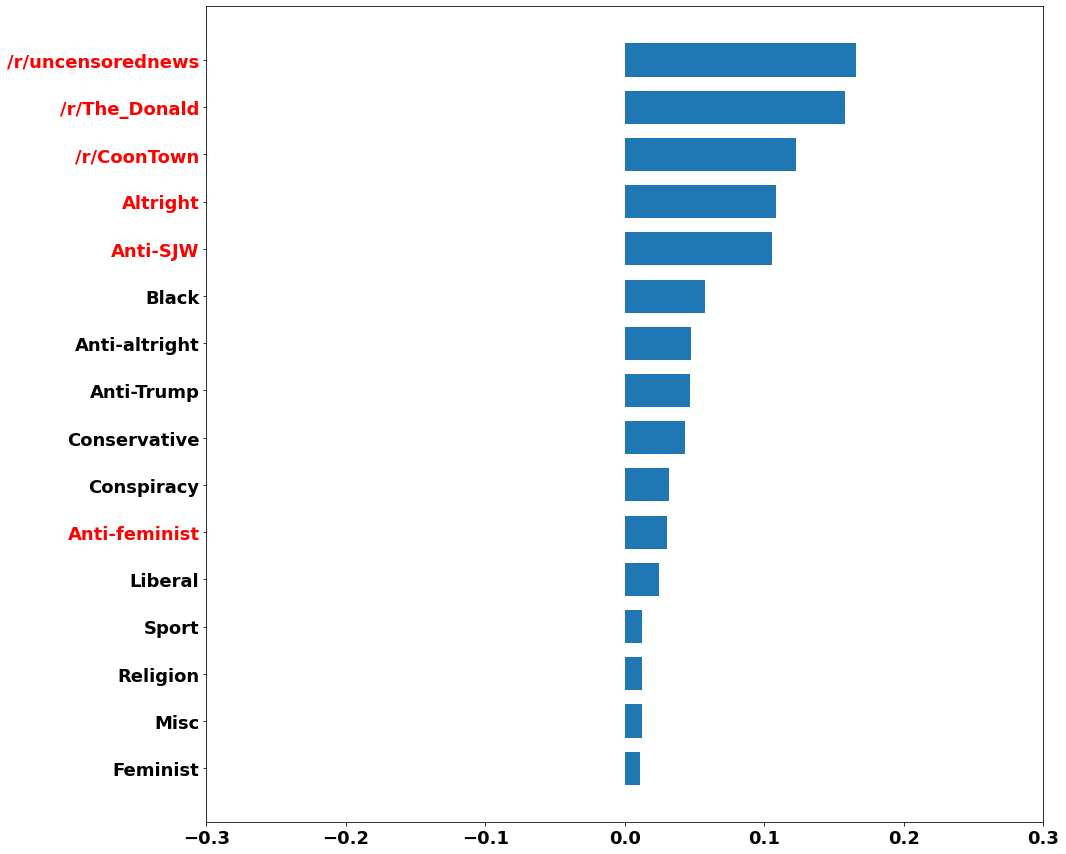

In [116]:
diff = hate_probs_gr.loc['yes',:]
diff = diff.sort_values(ascending = True)

alt_subreddits = ['/r/uncensorednews', '/r/CoonTown', '/r/The_Donald', 'Anti-SJW', 'Altright', 'Anti-feminist']
antihate = ['onguardforthee', 'AgainstHateSubreddits', 'Fuckthealtright', 'ShitRedditSays', 'esist', 'EnoughTrumpSpam', 'politics', 'socialjustice101']

width = 0.7
vals = diff.values
ind = np.arange(diff.shape[0])
fig, ax = plt.subplots(figsize = (15,15))
a = ax.barh(ind, vals, width)
ax.set_yticks(ind)
ax.set_yticklabels(diff.index)
ax.tick_params(labelsize=18)
ax.set_xlim([-0.3,0.3])
#fig.suptitle('Average probabilities for tweets classified as hatespeech', fontsize=20)
for i, ytick in enumerate(ax.get_yticklabels()):
    if diff.index[i] in alt_subreddits:
        ytick.set_color('red')
    elif diff.index[i] in antihate:
        ytick.set_color('green')
plt.savefig('figures/figure_A43a.pdf', bbox_inches='tight', pad_inches=1)


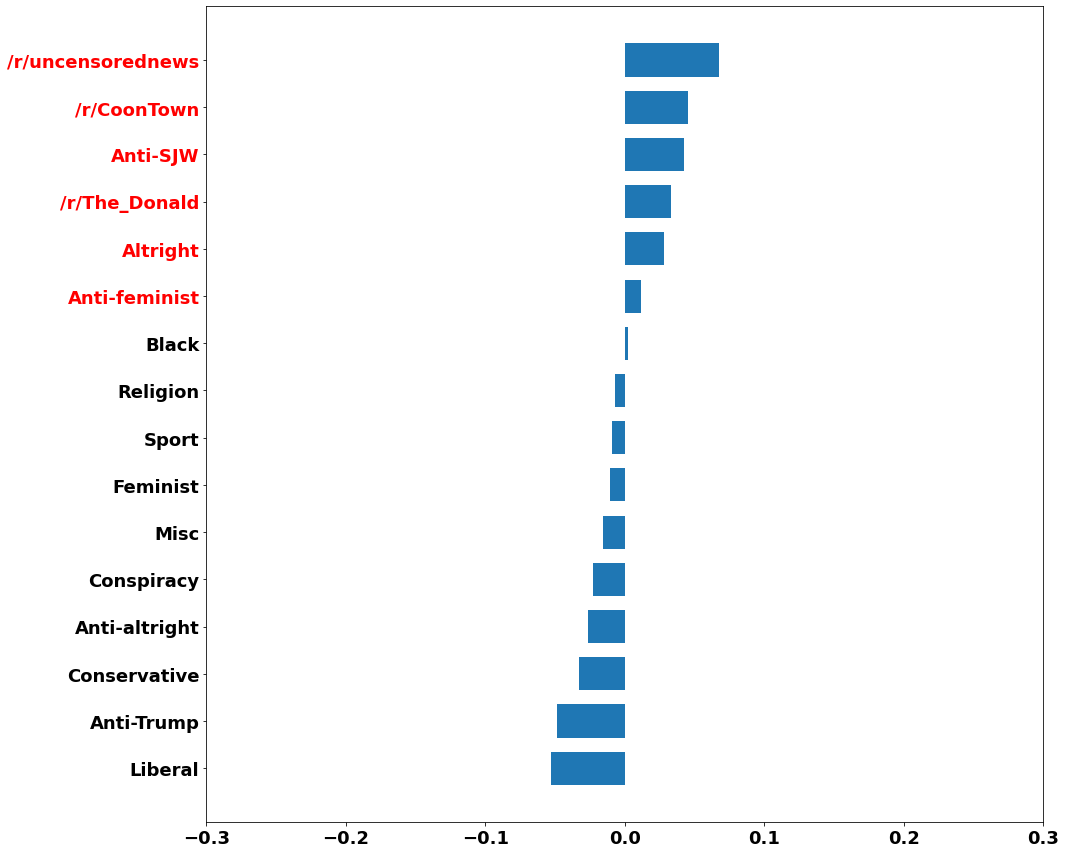

In [117]:
diff = hate_probs_gr.loc['yes',:] - hate_probs_gr.loc['no', :]
diff = diff.sort_values(ascending = True)

alt_subreddits = ['/r/uncensorednews', '/r/CoonTown', '/r/The_Donald', 'Anti-SJW', 'Altright', 'Anti-feminist']

width = 0.7
vals = diff.values
ind = np.arange(diff.shape[0])
fig, ax = plt.subplots(figsize = (15,15))
a = ax.barh(ind, vals, width)
ax.set_yticks(ind)
ax.set_yticklabels(diff.index)
ax.tick_params(labelsize=18)
ax.set_xlim([-0.3,0.3])
#fig.suptitle('Difference in average probabilities between classified as hatespeech and non-hatespeech', fontsize=20)
for i, ytick in enumerate(ax.get_yticklabels()):
    if diff.index[i] in alt_subreddits:
        ytick.set_color('red')
    elif diff.index[i] in antihate:
        ytick.set_color('green')
    plt.savefig('figures/figure_A43b.pdf', bbox_inches='tight', pad_inches=1)